In [105]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
import phate,scprep #scanpy, networkx, scprep, magic, phate, scipy, DiffusionEMD, pygsp, torch, sklearn
import rpy2, rpy2.situation, anndata2ri

In [2]:
print(os.getcwd())
data_dir = f"{os.getcwd()}/data"
kge_dir = f"{os.getcwd()}/KGEs"

/gpfs/ysm/home/fc489/yaleCollab


In this notebook I will explore using UCell to compute scores for the different pathways of the KG. These cell based scores can then be viewed by the old metadata levels (clusters/cytofgate) but also by clusters on the projections.

This represents a simpler approach that does not directly leverage graph structure, instead relying on "metadata" annotations for the KG nodes.

In [3]:
for i in rpy2.situation.iter_info(): # Print Rpy2 info
    print(i)

rpy2 version:
3.5.1
Python version:
3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:58:50) 
[GCC 10.3.0]
Looking for R's HOME:
    Environment variable R_HOME: /gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R
    Calling `R RHOME`: /gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:

R version:
    In the PATH: R version 4.1.3 (2022-03-10) -- "One Push-Up"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'rt', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/c

In [4]:
anndata2ri.activate() #This HAS TO be run b4 loading the rpy2 extension
%load_ext rpy2.ipython

In [5]:
%%R -i data_dir
library(tidyverse)
library(Seurat)
library(UCell)

print(data_dir)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

    consider that it could be called from a Python process. This
    results in a quasi-obligatory segfault when rpy2 is evaluating
    R code using it. On the hand, rpy2 is accounting for the
    fact that it might already be running embedded in a Python
    process. This is why:
    - Python -> rpy2 -> R -> reticulate: crashes
    - R -> reticulate -> Python -> rpy2: works

    The issue with reticulate is tracked here:
    https://github.com/rstudio/reticulate/issues/208
    

R[write to console]: Attaching SeuratObject

R[write to console]: Attaching sp



[1] "/gpfs/ysm/home/fc489/yaleCollab/data"


# Data ingestion

## KG

In [16]:
dKGlrp = pd.read_csv(f"{data_dir}/dKGlrp.csv.tar.gz", header=None)
dKGlrp

0                                           1                   2
0       CXCL1                                          LR               CXCR2
1       CXCL2                                          LR               CXCR2
2       CXCL3                                          LR               CXCR2
3       CXCL5                                          LR               CXCR2
4        PPBP                                          LR               CXCR2
...       ...                                         ...                 ...
25818  VEGFR2      Signaling by Receptor Tyrosine Kinases  p-\S*Y705\S*-STAT3
25819      GP                                   Apoptosis  p-\S*Y705\S*-STAT3
25820      GP                Cellular responses to stress  p-\S*Y705\S*-STAT3
25821      GP  Signaling by Non-Receptor Tyrosine Kinases  p-\S*Y705\S*-STAT3
25822     EBP                             MTOR signalling       p-\S+-RPS6\s+

[25823 rows x 3 columns]

In [20]:
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory

modelKGE = "KGlrp_50_unstratified_stopped_TransE_inverseTriples"

tf = TriplesFactory.from_labeled_triples(
        dKGlrp.to_numpy(dtype="str"),create_inverse_triples=("inverse" in modelKGE))
print(tf)
entityIDS = tf.entity_id_to_label
relationIDS = tf.relation_id_to_label

# try:
#     trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl")
# except RuntimeError:
#     trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl",
#     map_location=torch.device("cpu"))

# print(trained_model)

# #Construct nodes dataframe: detach() for now is meaningless as compute is CPU
# entity_embeddings = trained_model.entity_representations[0](indices=None).detach().cpu().numpy()
# dKGEnodes_50 = pd.DataFrame(entity_embeddings, index=entityIDS.values())
# dKGEnodes_50

TriplesFactory(num_entities=1630, num_relations=52, create_inverse_triples=True, num_triples=25823)


KG Entity metadata

In [19]:
dRPTMpath = pd.read_csv(f"{data_dir}/dLPTMpath.csv.tar.gz")
dRPTMpath

head                                    relation                tail
0       FLT4                          Signaling by NOTCH               H3F3A
1       EGFR                          Signaling by NOTCH               H3F3A
2       EGFR              Signaling by Nuclear Receptors               H3F3A
3        FAS              Signaling by Nuclear Receptors               H3F3A
4        CD2                          Signaling by NOTCH               H3F3A
...      ...                                         ...                 ...
3268  VEGFR2      Signaling by Receptor Tyrosine Kinases  p-\S*Y705\S*-STAT3
3269      GP                                   Apoptosis  p-\S*Y705\S*-STAT3
3270      GP                Cellular responses to stress  p-\S*Y705\S*-STAT3
3271      GP  Signaling by Non-Receptor Tyrosine Kinases  p-\S*Y705\S*-STAT3
3272     EBP                             MTOR signalling       p-\S+-RPS6\s+

[3273 rows x 3 columns]

In [21]:
PathDict = pd.read_csv(f"{data_dir}/DBs/ReactomePathways.txt", sep="\t", header=None)
PathDict = PathDict.loc[PathDict[2]=="Homo sapiens",[0,1]].drop_duplicates()
PathDict = PathDict.set_index([0]).to_dict()[1]

In [22]:
#Metadata
mdPath2Path = pd.read_csv(f"{data_dir}/DBs/ReactomePathwaysRelation.txt", sep="\t", header=None)
mdPath2Path = mdPath2Path.loc[mdPath2Path[0].isin([
                "R-HSA-162582",#Signal transduction
                "R-HSA-5357801",#Programmed cell death
                "R-HSA-73894",#DNA repair
                "R-HSA-8953897",#Cell response to stress
                "R-HSA-1500931",#Cell-cell commns
                "R-HSA-1640170"#Cell cycle
                                                    ])].drop_duplicates()
mdPath2Path = mdPath2Path.replace(PathDict)
mdPath2Path = mdPath2Path.loc[mdPath2Path[1].isin(relationIDS.values())]
mdPath2Path = mdPath2Path.set_index([1]).reindex(index=relationIDS.values()).fillna(value="LR").reset_index()
mdPath2Path.head()

1                              0
0                     Apoptosis          Programmed Cell Death
1           Cell Cycle, Mitotic                     Cell Cycle
2    Cell junction organization        Cell-Cell communication
3  Cellular responses to stress  Cellular responses to stimuli
4        Chromosome Maintenance                     Cell Cycle

In [25]:
dREACTpaths = pd.read_csv(f"{data_dir}/DBs/ReactomePathwaysRelation.txt", sep="\t", header=None)
dREACTpaths = dREACTpaths.loc[dREACTpaths[0].isin([
                "R-HSA-162582",#Signal transduction
                "R-HSA-5357801",#Programmed cell death
                "R-HSA-73894",#DNA repair
                "R-HSA-8953897",#Cell response to stress
                "R-HSA-1500931",#Cell-cell commns
                "R-HSA-1640170"#Cell cycle
                                                    ]),1]

mdPathPE = pd.read_csv(f"{data_dir}/DBs/Ensembl2Reactome_PE_All_Levels.txt", sep="\t", header=None)
mdPathPE = mdPathPE.loc[mdPathPE[0].str.startswith("ENSG")|mdPathPE[0].str.startswith("ENSP"),[1,2,3,5]].drop_duplicates()
mdPathPE = mdPathPE.loc[mdPathPE[3].isin(dREACTpaths)]
mdPathPE = mdPathPE.loc[mdPathPE[2].str.match("^\S*[A-Z0-9]+\S*[A-Z0-9]+(\sgene)?(\(\S+\))? \[")][[2,3,5]].dropna().drop_duplicates()
mdPathPE = mdPathPE.dropna().drop_duplicates()
mdPathPE = mdPathPE.groupby(by=[5])
mdPathPE.describe()

2         \
                                                   count unique   
5                                                                 
Apoptosis                                            321    321   
Base Excision Repair                                  76     76   
Cell Cycle Checkpoints                               328    328   
Cell Cycle, Mitotic                                  873    873   
Cell junction organization                           120    120   
Cellular responses to stress                        1130   1130   
Chromosome Maintenance                               121    121   
DNA Damage Bypass                                     66     66   
DNA Damage Reversal                                    9      9   
DNA Double-Strand Break Repair                       227    227   
Death Receptor Signalling                            245    245   
Fanconi Anemia Pathway                                55     55   
Integrin signaling                                    36     36   
Intracellular signaling by second messengers         415    415   
MAPK family signaling cascades                       504    504   
MTOR signalling                                       55     55   
Meiosis                                               92     92   
Mismatch Repair                                       15     15   
Nephrin family interactions                           24     24   
Nucleotide Excision Repair                           152    152   
Regulated Necrosis                                   115    115   
Response to metal ions                                16     16   
Signal regulatory protein family interactions         17     17   
Signaling by Erythropoietin                           33     33   
Signaling by GPCR                                    810    810   
Signaling by Hedgehog                                289    289   
Signaling by Hippo                                    38     38   
Signaling by Leptin                                   22     22   
Signaling by NOTCH                                   337    337   
Signaling by Non-Receptor Tyrosine Kinases            93     93   
Signaling by Nuclear Receptors                       354    354   
Signaling by Receptor Tyrosine Kinases               950    950   
Signaling by Rho GTPases, Miro GTPases and RHOBTB3   785    785   
Signaling by TGFB family members                     199    199   
Signaling by WNT                                     463    463   

                                                                                                    \
                                                                                               top   
5                                                                                                    
Apoptosis                                                       BAD [mitochondrial outer membrane]   
Base Excision Repair                                                            LIG3 [nucleoplasm]   
Cell Cycle Checkpoints                                                            MAD1L1 [cytosol]   
Cell Cycle, Mitotic                                                               MAD1L1 [cytosol]   
Cell junction organization                                                  CLDN11 [cell junction]   
Cellular responses to stress                                               GCLC gene [nucleoplasm]   
Chromosome Maintenance                                                        POLR2J [nucleoplasm]   
DNA Damage Bypass                                                              REV3L [nucleoplasm]   
DNA Damage Reversal                                                           ALKBH5 [nucleoplasm]   
DNA Double-Strand Break Repair                                          p-Y104-RAD52 [nucleoplasm]   
Death Receptor Signalling                                                     p-S128-BAD [cytosol]   
Fanconi Anemia Pathway                                                         E

In [27]:
mdEntities = pd.DataFrame(columns=["entity","pathway"])
for i in entityIDS.values():
    if any(mdPathPE.obj[2].str.contains(i)):
        for n in mdPathPE.obj.loc[mdPathPE.obj[2].str.contains(i)][5].unique():
            row = pd.Series({"entity":i, "pathway":n})
            mdEntities = pd.concat([mdEntities, row.to_frame().T])
    else:
        row = pd.Series({"entity":i})
        mdEntities = pd.concat([mdEntities, row.to_frame().T])
            
mdEntities = mdEntities.loc[mdEntities["pathway"].isin(relationIDS.values()) | mdEntities["pathway"].isna()] #Get only pathways wecare about from pur entity list
mdEntities["1stPathways"] = mdEntities["pathway"].map(mdPath2Path.set_index([1]).to_dict()[0])    

#Add entity type metadata
mdEntities["Ligands"] = mdEntities["entity"].isin(dKGlrp.loc[dKGlrp[1]=="LR"][0])
mdEntities["Receptors"] = mdEntities["entity"].isin(dKGlrp.loc[dKGlrp[1]=="LR"][2])
mdEntities["PTMs"] = mdEntities["entity"].isin(dRPTMpath["tail"])
# #DOES NOT WORK WITH PANDAS BELOW 1.5 (and collab env has 1.3.5....)
# mdEntities["EntityType"] = pd.from_dummies(mdEntities[["Ligands","Receptors","PTMs"]])
mdEntities

/tmp/ipykernel_22191/125279097.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if any(mdPathPE.obj[2].str.contains(i)):
/tmp/ipykernel_22191/125279097.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  for n in mdPathPE.obj.loc[mdPathPE.obj[2].str.contains(i)][5].unique():


entity                                            pathway  \
0                  A2M                                                NaN   
0                AANAT                                                NaN   
0                ABCA1                     Signaling by Nuclear Receptors   
0                ABCA7                                                NaN   
0                ACKR1                                                NaN   
..                 ...                                                ...   
0   p-\S+-MAPK(3|1)\s+  Signaling by Rho GTPases, Miro GTPases and RHO...   
0        p-\S+-RPS6\s+                                    MTOR signalling   
0    p-\S+-SMAD(1|5|9)                   Signaling by TGFB family members   
0      p-\S+-SMAD(2|3)                                 Signaling by NOTCH   
0      p-\S+-SMAD(2|3)                   Signaling by TGFB family members   

            1stPathways  Ligands  Receptors   PTMs  
0                   NaN     True      False  False  
0                   NaN     True      False  False  
0   Signal Transduction    False       True  False  
0                   NaN    False       True  False  
0                   NaN    False       True  False  
..                  ...      ...        ...    ...  
0   Signal Transduction    False      False   True  
0   Signal Transduction    False      False   True  
0   Signal Transduction    False      False   True  
0   Signal Transduction    False      False   True  
0   Signal Transduction    False      False   True  

[2172 rows x 6 columns]

## Single-cell datasets

In [6]:
mdSEQ = pd.read_csv(f"{data_dir}/mdSEQ.csv.tar.gz", index_col=0)
mdSEQ

orig.ident  nCount_RNA  nFeature_RNA  mito_content  \
WT__AAACCCACAGCTTCCT-1  cocultWTFib     10761.0          3163      0.947867   
WT__AAACCCAGTTCGAGCC-1  cocultWTFib     15485.0          3811      1.233452   
WT__AAACGAAAGAAGGATG-1  cocultWTFib     16689.0          3775      1.270298   
WT__AAACGAAAGGAAAGGT-1  cocultWTFib      5756.0          2126      1.476720   
WT__AAACGAAAGTTAACGA-1  cocultWTFib     40330.0          4714      0.451277   
...                             ...         ...           ...           ...   
WT__TTTGGTTTCATTCTTG-1  cocultWTFib      9953.0          2555      0.351653   
WT__TTTGGTTTCCGTAGTA-1  cocultWTFib     15622.0          3810      1.389067   
WT__TTTGTTGTCGCTTGAA-1  cocultWTFib     17046.0          3521      1.020767   
WT__TTTGTTGTCTGAATCG-1  cocultWTFib     35280.0          5510      0.600907   
WT__TTTGTTGTCTGGGTCG-1  cocultWTFib     24718.0          4499      0.712032   

                        rfp_content  gfp_content  nCount_SCT  nFeature_SCT  \
WT__AAACCCACAGCTTCCT-1     0.009293          0.0     17183.0          3206   
WT__AAACCCAGTTCGAGCC-1     0.000000          0.0     17347.0          3811   
WT__AAACGAAAGAAGGATG-1     0.000000          0.0     17508.0          3775   
WT__AAACGAAAGGAAAGGT-1     0.000000          0.0     16159.0          2915   
WT__AAACGAAAGTTAACGA-1     0.000000          0.0     18645.0          3719   
...                             ...          ...         ...           ...   
WT__TTTGGTTTCATTCTTG-1     0.000000          0.0     17085.0          2703   
WT__TTTGGTTTCCGTAGTA-1     0.006401          0.0     17299.0          3810   
WT__TTTGTTGTCGCTTGAA-1     0.000000          0.0     17569.0          3520   
WT__TTTGTTGTCTGAATCG-1     0.000000          0.0     18811.0          4957   
WT__TTTGTTGTCTGGGTCG-1     0.000000          0.0     18679.0          4463   

                         S.Score  G2M.Score    Phase    old.ident    CCDiff  \
WT__AAACCCACAGCTTCCT-1  0.091728  -0.035993  Cycling  cocultWTFib  0.127722   
WT__AAACCCAGTTCGAGCC-1  0.047732  -0.003214  Cycling  cocultWTFib  0.050946   
WT__AAACGAAAGAAGGATG-1  0.048829  -0.047012  Cycling  cocultWTFib  0.095840   
WT__AAACGAAAGGAAAGGT-1  0.042995  -0.003853  Cycling  cocultWTFib  0.046847   
WT__AAACGAAAGTTAACGA-1  0.011989  -0.003207  Cycling  cocultWTFib  0.015196   
...                          ...        ...      ...          ...       ...   
WT__TTTGGTTTCATTCTTG-1  0.056178  -0.011031  Cycling  cocultWTFib  0.067208   
WT__TTTGGTTTCCGTAGTA-1  0.087046  -0.010352  Cycling  cocultWTFib  0.097397   
WT__TTTGTTGTCGCTTGAA-1  0.035357   0.024285  Cycling  cocultWTFib  0.011072   
WT__TTTGTTGTCTGAATCG-1  0.056220   0.037295  Cycling  cocultWTFib  0.018924   
WT__TTTGTTGTCTGGGTCG-1  0.083789   0.011693  Cycling  cocultWTFib  0.072096   

                        SCT_snn_res.0.6  seurat_clusters        curatedCLUST  \
WT__AAACCCACAGCTTCCT-1                4                4                 NaN   
WT__AAACCCAGTTCGAGCC-1                2                2                 NaN   
WT__AAACGAAAGAAGGATG-1                2                2                 NaN   
WT__AAACGAAAGGAAAGGT-1                9                9     Late Absorptive   
WT__AAACGAAAGTTAACGA-1                5                5  Transit Amplifying   
...                                 ...              ...                 ...   
WT__TTTGGTTTCATTCTTG-1                8                8           ER Stress   
WT__TTTGGTTTCCGTAGTA-1                2                2                 NaN   
WT__TTTGTTGTCGCTTGAA-1                9                9     Late Absorptive   
WT__TTTGTTGTCTGAATCG-1                1                1                 NaN   
WT__TTTGTTGTCTGGGTCG-1                5                5  Transit Amplifying   

                           old.clust           finalPOPS     ident  
WT__AAACCCACAGCTTCCT-1    fibroblast          fibroblast     fCd34  
WT__AAACCCAGTTCGAGCC-1    fibroblast          fibroblast  fCd34frz  
WT__AAACGAAAGAAGGATG-1

In [7]:
dMagicRnaSeq = pd.read_csv(f"{data_dir}/dMagicRnaSeq.csv.tar.gz", index_col=0)
dMagicRnaSeq

ABCA1     ABCA7     ACKR3     ACKR4     ACVR1  \
WT__AAACCCACAGCTTCCT-1  0.176264  0.035152  0.313053  0.000024  0.131976   
WT__AAACCCAGTTCGAGCC-1  0.174236  0.044856  0.347521  0.000002  0.137324   
WT__AAACGAAAGAAGGATG-1  0.186200  0.017999  0.373453  0.000121  0.120973   
WT__AAACGAAAGGAAAGGT-1  0.000117  0.051364  0.000000  0.000000  0.033550   
WT__AAACGAAAGTTAACGA-1  0.000773  0.039822  0.000621  0.000000  0.097737   
...                          ...       ...       ...       ...       ...   
WT__TTTGGTTTCATTCTTG-1  0.002186  0.083757  0.000061  0.000000  0.072829   
WT__TTTGGTTTCCGTAGTA-1  0.249297  0.023920  0.453706  0.000248  0.154212   
WT__TTTGTTGTCGCTTGAA-1  0.001755  0.045683  0.000054  0.000000  0.058815   
WT__TTTGTTGTCTGAATCG-1  0.183233  0.042192  0.087850  0.000113  0.139526   
WT__TTTGTTGTCTGGGTCG-1  0.000427  0.026164  0.000368  0.000000  0.090308   

                          ACVR1B    ACVR2A    ACVR2B    ACVRL1    ADAM12  ...  \
WT__AAACCCACAGCTTCCT-1  0.081673  0.049884  0.006515  0.009460  0.049402  ...   
WT__AAACCCAGTTCGAGCC-1  0.079288  0.054080  0.011059  0.016255  0.066180  ...   
WT__AAACGAAAGAAGGATG-1  0.099487  0.037851  0.005322  0.012983  0.040916  ...   
WT__AAACGAAAGGAAAGGT-1  0.062326  0.069992  0.013247  0.013083  0.000000  ...   
WT__AAACGAAAGTTAACGA-1  0.036481  0.043880  0.016335  0.000179  0.000026  ...   
...                          ...       ...       ...       ...       ...  ...   
WT__TTTGGTTTCATTCTTG-1  0.076888  0.084281  0.088401  0.000422  0.000021  ...   
WT__TTTGGTTTCCGTAGTA-1  0.119778  0.034443  0.003957  0.003030  0.057927  ...   
WT__TTTGTTGTCGCTTGAA-1  0.045155  0.064709  0.022273  0.004514  0.000000  ...   
WT__TTTGTTGTCTGAATCG-1  0.050981  0.041564  0.010275  0.239226  0.022962  ...   
WT__TTTGTTGTCTGGGTCG-1  0.027119  0.043246  0.017967  0.000000  0.000103  ...   

                            WNT2     WNT2B      WNT4     WNT5A     WNT5B  \
WT__AAACCCACAGCTTCCT-1  0.006698  0.002012  1.350994  0.118889  0.086329   
WT__AAACCCAGTTCGAGCC-1  0.006134  0.001122  1.377690  0.168283  0.074230   
WT__AAACGAAAGAAGGATG-1  0.014108  0.000803  1.410074  0.153546  0.066795   
WT__AAACGAAAGGAAAGGT-1  0.000000  0.000000  0.133904  0.000000  0.000000   
WT__AAACGAAAGTTAACGA-1  0.000485  0.000000  0.050542  0.000547  0.000318   
...                          ...       ...       ...       ...       ...   
WT__TTTGGTTTCATTCTTG-1  0.000006  0.000000  0.019581  0.000774  0.000372   
WT__TTTGGTTTCCGTAGTA-1  0.005783  0.001245  1.669304  0.136010  0.082518   
WT__TTTGTTGTCGCTTGAA-1  0.000000  0.000000  0.063703  0.001944  0.000160   
WT__TTTGTTGTCTGAATCG-1  0.002344  0.000000  0.229349  0.128302  0.024434   
WT__TTTGTTGTCTGGGTCG-1  0.000069  0.000000  0.033969  0.000137  0.000275   

                            WNT6     WNT7A     WNT7B     WNT9A      XPR1  
WT__AAACCCACAGCTTCCT-1  0.001611  0.000080  0.001189  0.003603  0.069818  
WT__AAACCCAGTTCGAGCC-1  0.001645  0.000112  0.000071  0.001999  0.066110  
WT__AAACGAAAGAAGGATG-1  0.001096  0.000034  0.000264  0.010773  0.073940  
WT__AAACGAAAGGAAAGGT-1  0.000012  0.004001  0.026078  0.000675  0.109556  
WT__AAACGAAAGTTAACGA-1  0.000231  0.026103  0.135859  0.001077  0.062340  
...                          ...       ...       ...       ...       ...  
WT__TTTGGTTTCATTCTTG-1  0.000006  0.024542  0.125214  0.001002  0.078681  
WT__TTTGGTTTCCGTAGTA-1  0.000680  0.000005  0.000231  0.002954  0.102031  
WT__TTTGTTGTCGCTTGAA-1  0.000912  0.010024  0.059745  0.002059  0.064672  
WT__TTTGTTGTCTGAATCG-1  0.000964  0.000137  0.004162  0.000640  0.094995  
WT__TTTGTTGTCTGGGTCG-1  0.000621  0.079158  0.199716  0.000345  0.074621  

[3698 rows x 931 columns]

In [8]:
mdCYT = pd.read_csv(f"{data_dir}/mdCYT.csv.tar.gz", index_col=0)
mdCYT

file_identifier
0       Pro_WTfib_fib
1       Pro_WTfib_fib
2       Pro_WTfib_fib
3       Pro_WTfib_fib
4       Pro_WTfib_fib
...               ...
23944   Pro_WTfib_epi
23945   Pro_WTfib_epi
23946   Pro_WTfib_epi
23947   Pro_WTfib_epi
23948   Pro_WTfib_epi

[23145 rows x 1 columns]

In [9]:
dMagicCyt = pd.read_csv(f"{data_dir}/dMagicCyt.csv.tar.gz", index_col=0)
dMagicCyt

BAD       BTK     CASP3     GSK3B     H3F3A      PDK1      RELA  \
0      3.899616  2.784834  1.310884  5.449692  0.969921  5.028474  3.649563   
1      3.955915  2.853634  1.348455  5.451652  0.989181  5.075293  3.722382   
2      0.906135  3.047424  1.028126  2.665144  0.360074  4.005344  3.737603   
3      2.260774  2.284370  1.319299  3.665524  0.476188  4.107901  2.836324   
4      0.399051  1.698516  1.399915  2.377341  0.145084  2.025643  1.857168   
...         ...       ...       ...       ...       ...       ...       ...   
23944  1.196790  1.586073  0.930401  2.328783  0.429739  3.946099  2.104690   
23945  1.000133  1.752572  0.788834  2.291807  0.612318  4.237323  2.715193   
23946  1.565686  2.038212  1.037187  0.844546  0.357192  3.646550  2.450377   
23947  0.224585  0.694442  0.472122  0.135704  0.122947  0.687698  0.963550   
23948  1.083656  1.764151  0.781870  0.906697  0.296129  3.328213  2.124206   

       p-\S*S133\S*-CREB1  p-\S*S257\S*-MAP2K4  p-\S*S473\S*-AKT1  ...  \
0                1.828986             4.063050           4.882569  ...   
1                1.861730             4.133732           4.899646  ...   
2                0.596735             3.220904           0.718287  ...   
3                1.068728             2.429595           2.246978  ...   
4                0.241485             1.136082           0.310228  ...   
...                   ...                  ...                ...  ...   
23944            0.431434             0.794512           0.724156  ...   
23945            0.364882             0.777315           0.556517  ...   
23946            0.528283             1.318566           0.973948  ...   
23947            0.167771             0.456217           0.148095  ...   
23948            0.399103             0.758581           0.530932  ...   

       p-\S*T308\S*-AKT1  p-\S*T334\S*-MAPKAPK2  p-\S*T359\S*-RPS6KA1  \
0               3.494137               0.962294              3.657536   
1               3.521848               0.967380              3.696468   
2               0.964845               1.812618              3.570309   
3               1.735075               1.488912              2.400010   
4               0.325917               0.540326              0.995234   
...                  ...                    ...                   ...   
23944           0.602622               1.389400              1.245188   
23945           0.576977               1.232210              1.339332   
23946           1.062217               1.696508              1.570726   
23947           0.123670               0.466107              0.302848   
23948           0.675034               1.379966              1.074965   

       p-\S*T37,T46\S*-EIF4EBP1  p-\S*Y41\S*-SRC  p-\S*Y705\S*-STAT3  \
0                      5.519432         2.065293            2.623868   
1                      5.523423         2.075914            2.655060   
2                      1.603776         1.147961            0.962103   
3                      3.086521         1.385351            2.476036   
4                      0.495354         0.486995            0.430875   
...                         ...              ...                 ...   
23944                  1.165265         0.663343            2.076410   
23945                  1.222818         0.685648            1.816584   
23946                  1.511276         1.048415            2.384323   
23947                  0.210735         0.294054            0.225146   
23948                  1.293127         0.690818            0.852355   

       p-\S+-MAPK(3|1)\s+  p-\S+-RPS6\s+  p-\S+-SMAD(1|5|9)  p-\S+-SMAD(2|3)  
0                4.548958       6.465075           2.613067         3.826031  
1                4.659614       6.462107           2.692873         3.940166  
2                4.438853       0.512113           0.631681         4.096544  
3                3.489248       3.203275           1.191940         3.543021  
4                1.657132       1.265

## Projection

In [11]:
multi_projection = np.load(f"{data_dir}/multi_projection_KGlrp_inverseTransE_WTfib.npz")
multi_projection

In [14]:
multi_projection["seq_projection"].shape

(3698, 6520)

In [15]:
multi_projection["cyt_projection"].shape

(23145, 6520)

# UCell scores
Per each pathway, define list of nodes associated with.
Then compute scores for pathways on scRNAseq and cytof cells.
Finally view score distribution for each pathway on each modality, split by cell metadata (for now old cluster, but also compute "functional communication clusters").

In [38]:
dictPath2Ent = {}
for name,group in mdEntities.groupby(by="pathway"):
    print(name)
    dictPath2Ent[name] = list(group["entity"].drop_duplicates())

Apoptosis
Cell Cycle, Mitotic
Cell junction organization
Cellular responses to stress
Chromosome Maintenance
Death Receptor Signalling
Integrin signaling
Intracellular signaling by second messengers
MAPK family signaling cascades
MTOR signalling
Meiosis
Nephrin family interactions
Regulated Necrosis
Signaling by Erythropoietin
Signaling by GPCR
Signaling by Hedgehog
Signaling by Hippo
Signaling by Leptin
Signaling by NOTCH
Signaling by Non-Receptor Tyrosine Kinases
Signaling by Nuclear Receptors
Signaling by Receptor Tyrosine Kinases
Signaling by Rho GTPases, Miro GTPases and RHOBTB3
Signaling by TGFB family members
Signaling by WNT


In [ ]:
import json
with open(f"{data_dir}/dictPath2Ent.json","w") as outf:
    json.dump(dictPath2Ent, outf)

In [81]:
Apoptosis = dictPath2Ent["Apoptosis"]
CellCycleMitotic = dictPath2Ent["Cell Cycle, Mitotic"]
Celljunctionorganization = dictPath2Ent["Cell junction organization"]
Cellularresponsestostress = dictPath2Ent["Cellular responses to stress"]
ChromosomeMaintenance = dictPath2Ent["Chromosome Maintenance"]
DeathReceptorSignalling = dictPath2Ent["Death Receptor Signalling"]
Integrinsignaling = dictPath2Ent["Integrin signaling"]
Intracellularsignalingbysecondmessengers = dictPath2Ent["Intracellular signaling by second messengers"]
MAPKfamilysignalingcascades = dictPath2Ent["MAPK family signaling cascades"]
MTORsignalling = dictPath2Ent["MTOR signalling"]
Meiosis = dictPath2Ent["Meiosis"]
Nephrinfamilyinteractions = dictPath2Ent["Nephrin family interactions"]
RegulatedNecrosis = dictPath2Ent["Regulated Necrosis"]
SignalingErythropoietin = dictPath2Ent["Signaling by Erythropoietin"]
SignalingGPCR = dictPath2Ent["Signaling by GPCR"]
SignalingHedgehog = dictPath2Ent["Signaling by Hedgehog"]
SignalingHippo = dictPath2Ent["Signaling by Hippo"]
SignalingLeptin = dictPath2Ent["Signaling by Leptin"]
SignalingNOTCH = dictPath2Ent["Signaling by NOTCH"]
SignalingNonReceptorTyrosineKinases = dictPath2Ent["Signaling by Non-Receptor Tyrosine Kinases"]
SignalingNuclearReceptors = dictPath2Ent["Signaling by Nuclear Receptors"]
SignalingReceptorTyrosineKinases = dictPath2Ent["Signaling by Receptor Tyrosine Kinases"]
SignalingRhoGTPasesMiroGTPasesRHOBTB3 = dictPath2Ent["Signaling by Rho GTPases, Miro GTPases and RHOBTB3"]
SignalingTGFBfamilymembers = dictPath2Ent["Signaling by TGFB family members"]
SignalingWNT = dictPath2Ent["Signaling by WNT"]

In [87]:
%%R -i dMagicRnaSeq,Apoptosis,CellCycleMitotic,Celljunctionorganization,Cellularresponsestostress,ChromosomeMaintenance,DeathReceptorSignalling,Integrinsignaling,Intracellularsignalingbysecondmessengers,MAPKfamilysignalingcascades,MTORsignalling,Meiosis,Nephrinfamilyinteractions,RegulatedNecrosis,SignalingErythropoietin,SignalingGPCR,SignalingHedgehog,SignalingHippo,SignalingLeptin,SignalingNOTCH,SignalingNonReceptorTyrosineKinases,SignalingNuclearReceptors,SignalingReceptorTyrosineKinases,SignalingRhoGTPasesMiroGTPasesRHOBTB3,SignalingTGFBfamilymembers,SignalingWNT -o scores

gene.sets <- list(
    "Apoptosis"=Apoptosis,
    "CellCycleMitotic" = CellCycleMitotic,
    "Celljunctionorganization"=Celljunctionorganization,
    "Cellularresponsestostress" = Cellularresponsestostress,
    "ChromosomeMaintenance"=ChromosomeMaintenance,
    "DeathReceptorSignalling" = DeathReceptorSignalling,
    "Integrinsignaling"=Integrinsignaling,
    "Intracellularsignalingbysecondmessengers" = Intracellularsignalingbysecondmessengers,
    "MAPKfamilysignalingcascades"=MAPKfamilysignalingcascades,
    "MTORsignalling" = MTORsignalling,
    "Meiosis"=Meiosis,
    "Nephrinfamilyinteractions" = Nephrinfamilyinteractions,
    "RegulatedNecrosis"=RegulatedNecrosis,
    "SignalingErythropoietin" = SignalingErythropoietin,
    "SignalingGPCR"=SignalingGPCR,
    "SignalingHedgehog" = SignalingHedgehog,
    "SignalingHippo"=SignalingHippo,
    "SignalingLeptin" = SignalingLeptin,
    "SignalingNOTCH"=SignalingNOTCH,
    "SignalingNonReceptorTyrosineKinases" = SignalingNonReceptorTyrosineKinases,
    "SignalingNuclearReceptors"=SignalingNuclearReceptors,
    "SignalingReceptorTyrosineKinases" = SignalingReceptorTyrosineKinases,
    "SignalingRhoGTPasesMiroGTPasesRHOBTB3" = SignalingRhoGTPasesMiroGTPasesRHOBTB3,
    "SignalingTGFBfamilymembers" = SignalingTGFBfamilymembers,
    "SignalingWNT" = SignalingWNT
)
scores <- ScoreSignatures_UCell(t(dMagicRnaSeq), features=gene.sets)
dim(scores)

[1] 3698   25


In [88]:
scores

array([[0.4648646 , 0.46042648, 0.49969475, ..., 0.50739974, 0.60501483,
        0.57620456],
       [0.47208595, 0.47285453, 0.49079888, ..., 0.50822749, 0.60087214,
        0.57241879],
       [0.46814168, 0.45650183, 0.49944401, ..., 0.50033538, 0.60594802,
        0.57280522],
       ...,
       [0.53514521, 0.44433543, 0.5588697 , ..., 0.51177394, 0.59232514,
        0.52371694],
       [0.47492151, 0.46503794, 0.54159035, ..., 0.49338519, 0.63736264,
        0.53939742],
       [0.51939757, 0.42525183, 0.56884485, ..., 0.52099329, 0.56997209,
        0.54771767]])

In [92]:
sPathSEQ = pd.DataFrame(index=dMagicRnaSeq.index, data=scores, columns=dictPath2Ent.keys())
sPathSEQ.describe()

Apoptosis  Cell Cycle, Mitotic  Cell junction organization  \
count  3698.000000          3698.000000                 3698.000000   
mean      0.485576             0.451761                    0.528810   
std       0.025997             0.017302                    0.030223   
min       0.452198             0.394656                    0.474054   
25%       0.466888             0.441919                    0.501810   
50%       0.471914             0.456338                    0.519988   
75%       0.515910             0.463493                    0.561066   
max       0.551158             0.492216                    0.600231   

       Cellular responses to stress  Chromosome Maintenance  \
count                   3698.000000             3698.000000   
mean                       0.534034                0.486264   
std                        0.014436                0.039985   
min                        0.507153                0.362209   
25%                        0.523770                0.460477   
50%                        0.529316                0.500731   
75%                        0.543889                0.514200   
max                        0.588134                0.546132   

       Death Receptor Signalling  Integrin signaling  \
count                3698.000000         3698.000000   
mean                    0.576597            0.463749   
std                     0.009151            0.015874   
min                     0.541001            0.394035   
25%                     0.571074            0.458875   
50%                     0.576692            0.467145   
75%                     0.582233            0.473537   
max                     0.611575            0.505943   

       Intracellular signaling by second messengers  \
count                                   3698.000000   
mean                                       0.514262   
std                                        0.007414   
min                                        0.499170   
25%                                        0.509085   
50%                                        0.512193   
75%                                        0.518708   
max                                        0.541276   

       MAPK family signaling cascades  MTOR signalling  ...  \
count                     3698.000000      3698.000000  ...   
mean                         0.539816         0.403650  ...   
std                          0.006734         0.012818  ...   
min                          0.513001         0.363717  ...   
25%                          0.537400         0.395469  ...   
50%                          0.541282         0.403503  ...   
75%                          0.544070         0.410555  ...   
max                          0.555145         0.454818  ...   

       Signaling by Hedgehog  Signaling by Hippo  Signaling by Leptin  \
count            3698.000000         3698.000000          3698.000000   
mean                0.516699            0.766550             0.173803   
std                 0.011065            0.059909             0.027796   
min                 0.474918            0.676609             0.139325   
25%                 0.510976            0.723312             0.153454   
50%                 0.518089            0.738226             0.161303   
75%                 0.523833            0.834772             0.191130   
max                 0.552769            0.904631             0.275903   

       Signaling by NOTCH  Signaling by Non-Receptor Tyrosine Kinases  \
count         3698.000000                                 3698.000000   
mean             0.495799                                    0.518493   
std              0.009330                                    0.016703   
min              0.472348                                    0.470611   
25%              0.489482                                    0.507295   
50%              0.495033                                    0.514429   
75%              0.500549                                    0.

In [93]:
%%R -i dMagicCyt,Apoptosis,CellCycleMitotic,Celljunctionorganization,Cellularresponsestostress,ChromosomeMaintenance,DeathReceptorSignalling,Integrinsignaling,Intracellularsignalingbysecondmessengers,MAPKfamilysignalingcascades,MTORsignalling,Meiosis,Nephrinfamilyinteractions,RegulatedNecrosis,SignalingErythropoietin,SignalingGPCR,SignalingHedgehog,SignalingHippo,SignalingLeptin,SignalingNOTCH,SignalingNonReceptorTyrosineKinases,SignalingNuclearReceptors,SignalingReceptorTyrosineKinases,SignalingRhoGTPasesMiroGTPasesRHOBTB3,SignalingTGFBfamilymembers,SignalingWNT -o scores

gene.sets <- list(
    "Apoptosis"=Apoptosis,
    "CellCycleMitotic" = CellCycleMitotic,
    "Celljunctionorganization"=Celljunctionorganization,
    "Cellularresponsestostress" = Cellularresponsestostress,
    "ChromosomeMaintenance"=ChromosomeMaintenance,
    "DeathReceptorSignalling" = DeathReceptorSignalling,
    "Integrinsignaling"=Integrinsignaling,
    "Intracellularsignalingbysecondmessengers" = Intracellularsignalingbysecondmessengers,
    "MAPKfamilysignalingcascades"=MAPKfamilysignalingcascades,
    "MTORsignalling" = MTORsignalling,
    "Meiosis"=Meiosis,
    "Nephrinfamilyinteractions" = Nephrinfamilyinteractions,
    "RegulatedNecrosis"=RegulatedNecrosis,
    "SignalingErythropoietin" = SignalingErythropoietin,
    "SignalingGPCR"=SignalingGPCR,
    "SignalingHedgehog" = SignalingHedgehog,
    "SignalingHippo"=SignalingHippo,
    "SignalingLeptin" = SignalingLeptin,
    "SignalingNOTCH"=SignalingNOTCH,
    "SignalingNonReceptorTyrosineKinases" = SignalingNonReceptorTyrosineKinases,
    "SignalingNuclearReceptors"=SignalingNuclearReceptors,
    "SignalingReceptorTyrosineKinases" = SignalingReceptorTyrosineKinases,
    "SignalingRhoGTPasesMiroGTPasesRHOBTB3" = SignalingRhoGTPasesMiroGTPasesRHOBTB3,
    "SignalingTGFBfamilymembers" = SignalingTGFBfamilymembers,
    "SignalingWNT" = SignalingWNT
)
scores <- ScoreSignatures_UCell(t(dMagicCyt), features=gene.sets)
dim(scores)

[1] 23145    25


In [96]:
sPathCYT = pd.DataFrame(index=dMagicCyt.index, data=scores, columns=dictPath2Ent.keys())
sPathCYT.describe()

Apoptosis  Cell Cycle, Mitotic  Cell junction organization  \
count  23145.000000         23145.000000                23145.000000   
mean       0.571228             0.623264                    0.506683   
std        0.000242             0.000664                    0.000004   
min        0.570489             0.621659                    0.506075   
25%        0.571066             0.622823                    0.506683   
50%        0.571218             0.623228                    0.506683   
75%        0.571400             0.623684                    0.506683   
max        0.572160             0.625405                    0.506683   

       Cellular responses to stress  Chromosome Maintenance  \
count                  23145.000000            23145.000000   
mean                       0.630125                0.535757   
std                        0.000196                0.000340   
min                        0.629198                0.534961   
25%                        0.629989                0.535624   
50%                        0.630127                0.535624   
75%                        0.630241                0.535734   
max                        0.630906                0.538275   

       Death Receptor Signalling  Integrin signaling  \
count               23145.000000        23145.000000   
mean                    0.549750            0.599148   
std                     0.000279            0.000648   
min                     0.548728            0.597856   
25%                     0.549550            0.598724   
50%                     0.549764            0.598985   
75%                     0.549979            0.599332   
max                     0.550479            0.601849   

       Intracellular signaling by second messengers  \
count                                  23145.000000   
mean                                       0.572027   
std                                        0.000115   
min                                        0.571385   
25%                                        0.571951   
50%                                        0.572034   
75%                                        0.572103   
max                                        0.572490   

       MAPK family signaling cascades  MTOR signalling  ...  \
count                    23145.000000     23145.000000  ...   
mean                         0.556151         0.737862  ...   
std                          0.000028         0.001720  ...   
min                          0.555518         0.734356  ...   
25%                          0.556131         0.736330  ...   
50%                          0.556153         0.737697  ...   
75%                          0.556164         0.739064  ...   
max                          0.556274         0.743013  ...   

       Signaling by Hedgehog  Signaling by Hippo  Signaling by Leptin  \
count           23145.000000        23145.000000         23145.000000   
mean                0.521043            0.736665             0.653998   
std                 0.000402            0.003367             0.002973   
min                 0.520242            0.729951             0.648441   
25%                 0.520629            0.733597             0.650871   
50%                 0.521236            0.736027             0.654921   
75%                 0.521402            0.739672             0.656541   
max                 0.521567            0.743317             0.658161   

       Signaling by NOTCH  Signaling by Non-Receptor Tyrosine Kinases  \
count        23145.000000                                23145.000000   
mean             0.576760                                    0.524674   
std              0.000250                                    0.000525   
min              0.575872                                    0.523694   
25%              0.576601                                    0.524123   
50%              0.576705                                    0.524837   
75%              0.576844                              

## View computed scores

Calculating PHATE...
  Running PHATE on 3698 observations and 931 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.13 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.40 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.58 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.18 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.06 seconds.
  Calculated landmark operator in 4.28 seconds.
  Calculating optimal t...
    Automatically selected t = 52
  Calculated optimal t in 0.83 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.47 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.07 seconds.
Calculated PHATE in 10.24 seconds.


/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw)


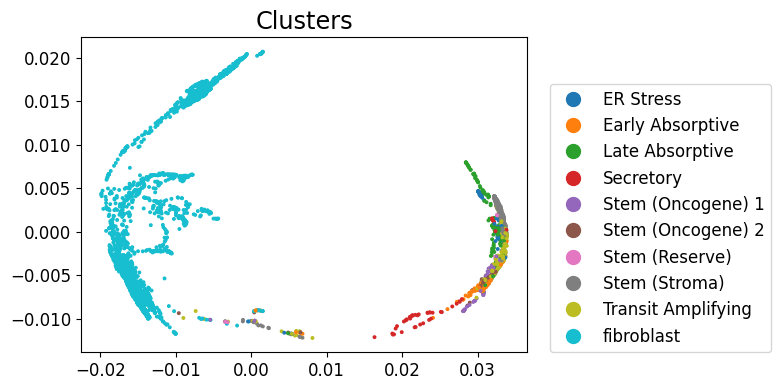

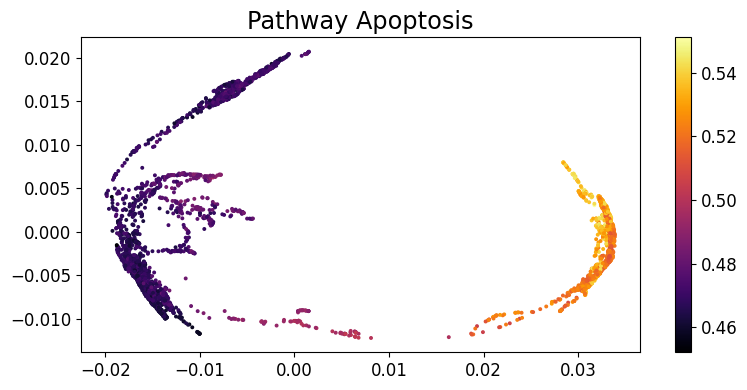

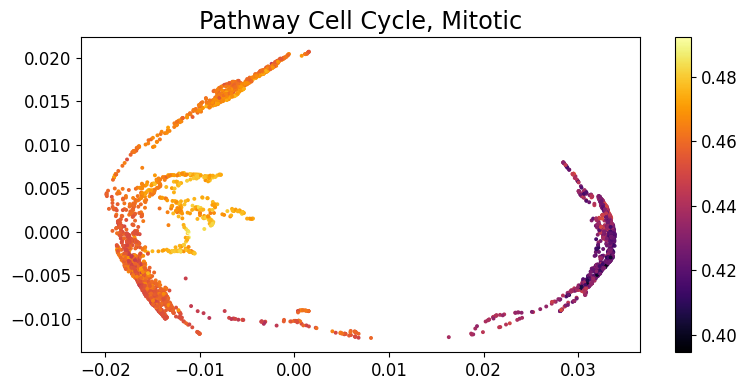

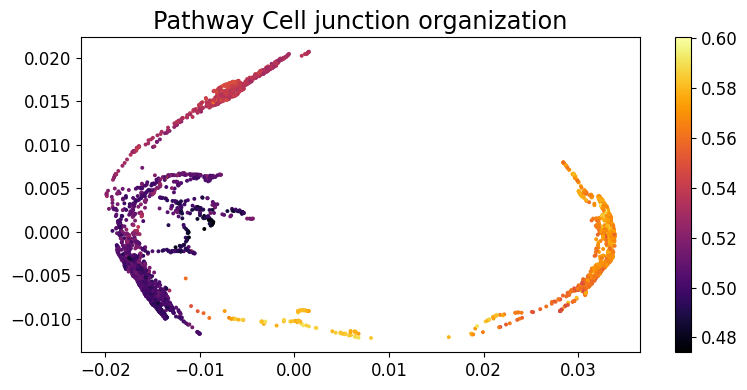

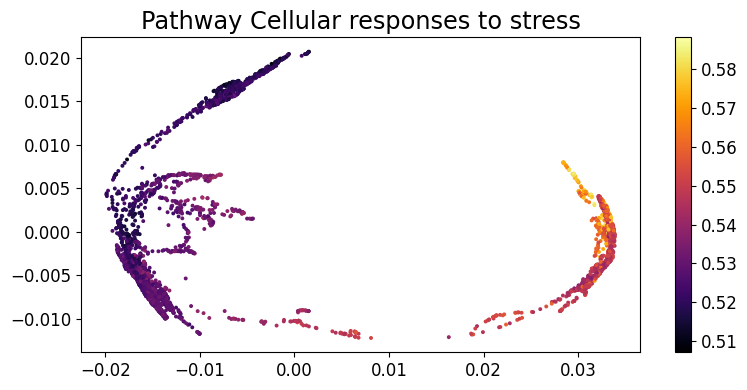

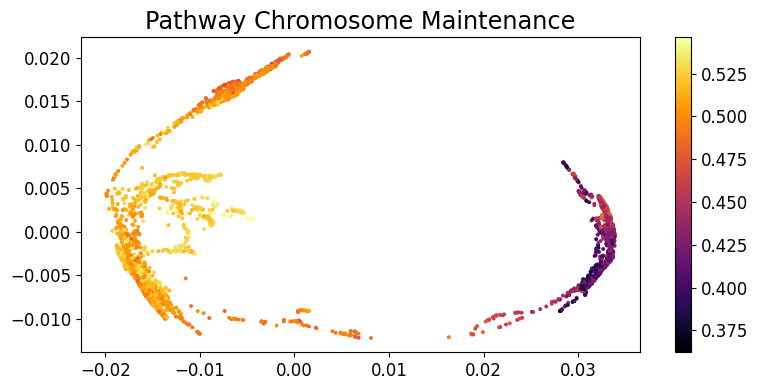

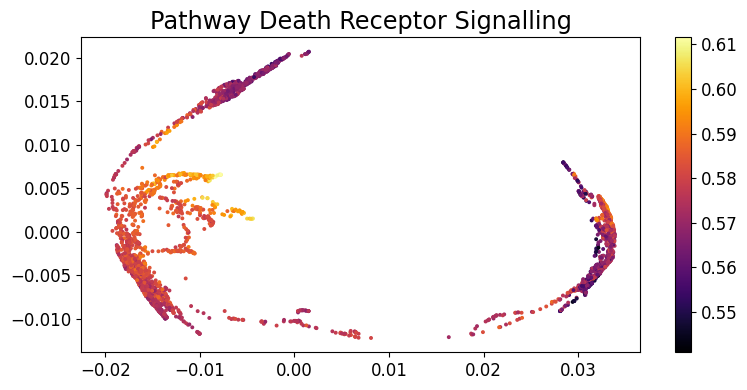

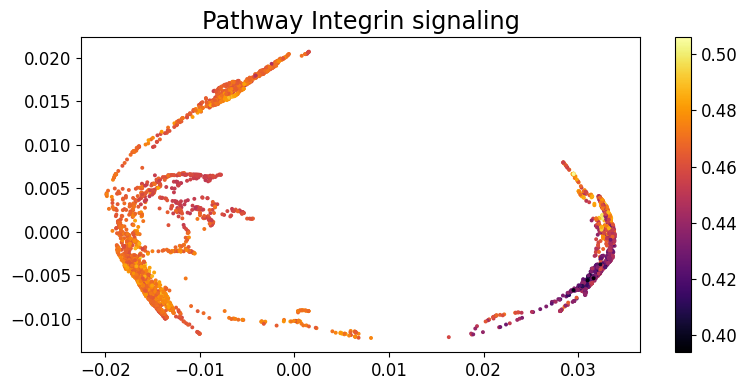

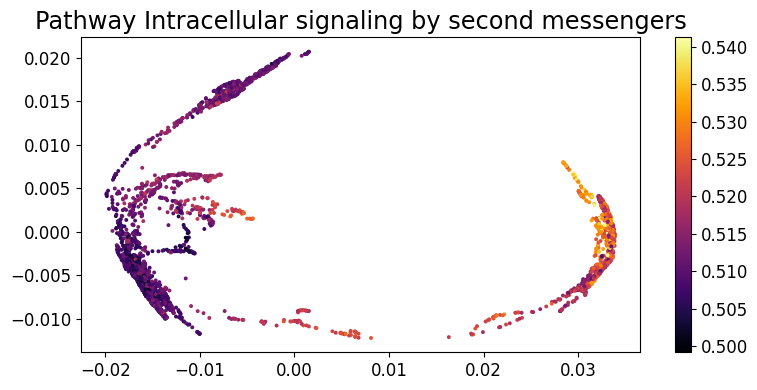

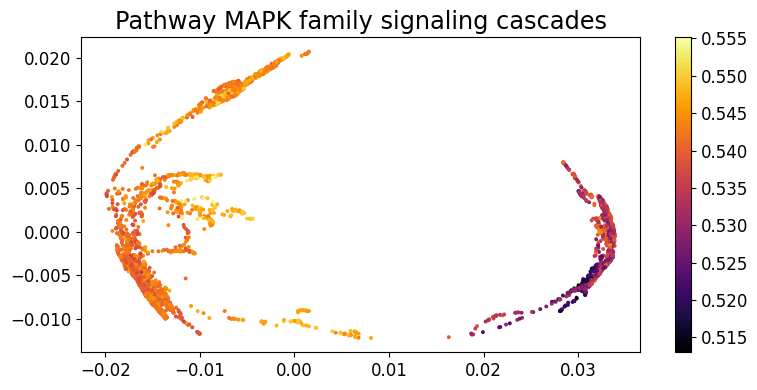

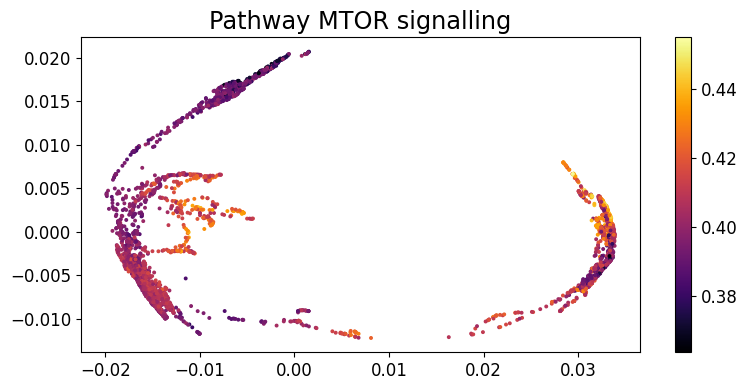

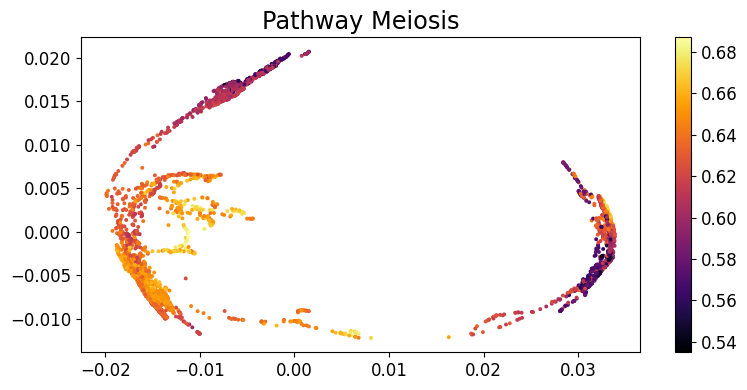

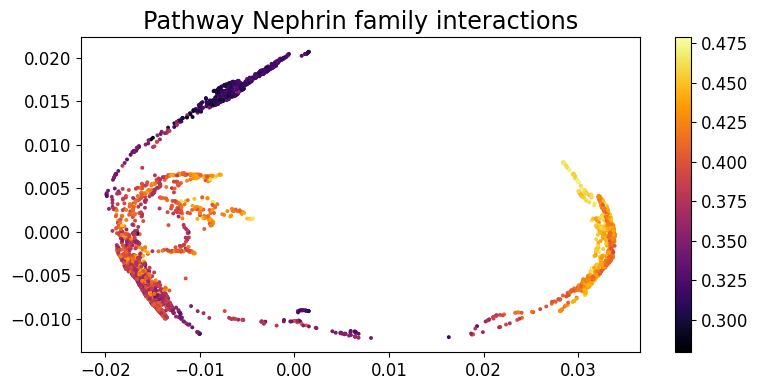

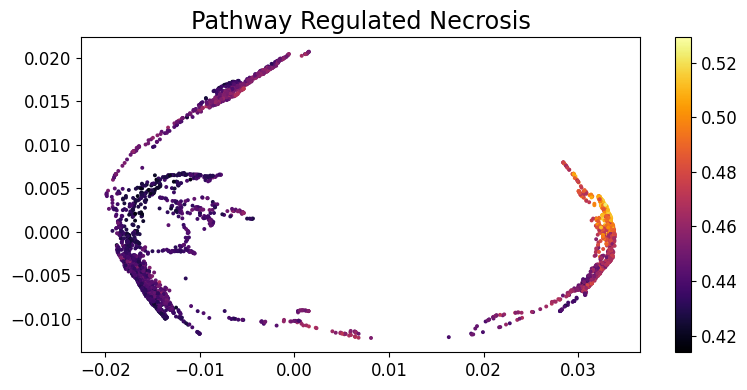

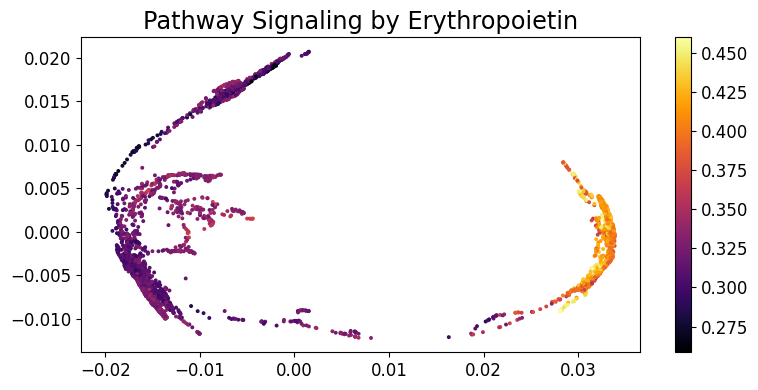

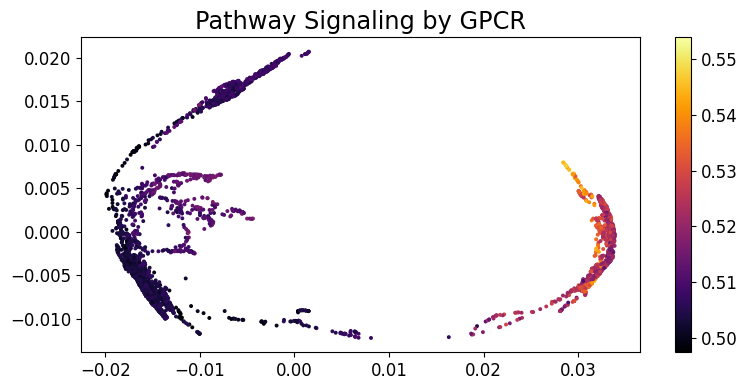

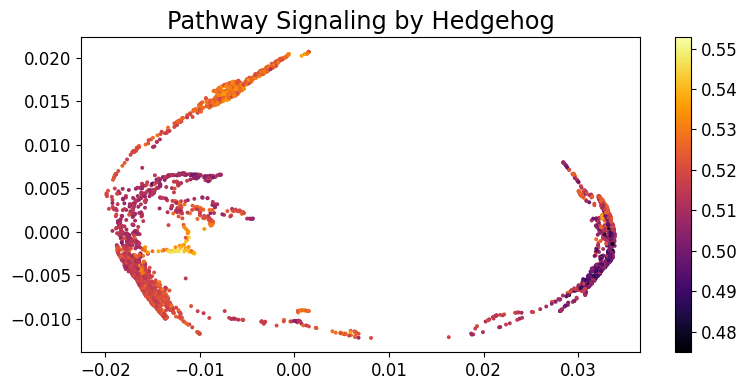

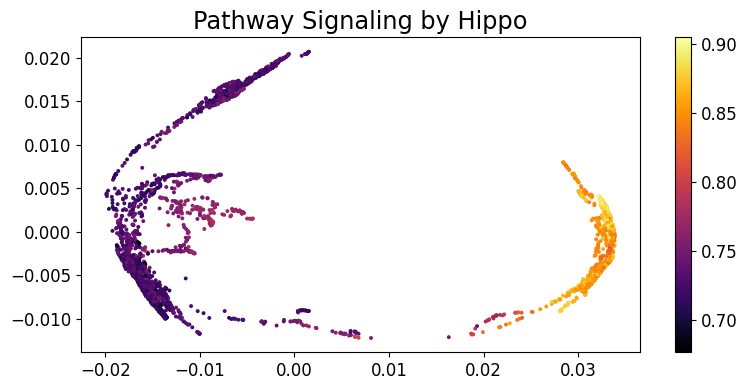

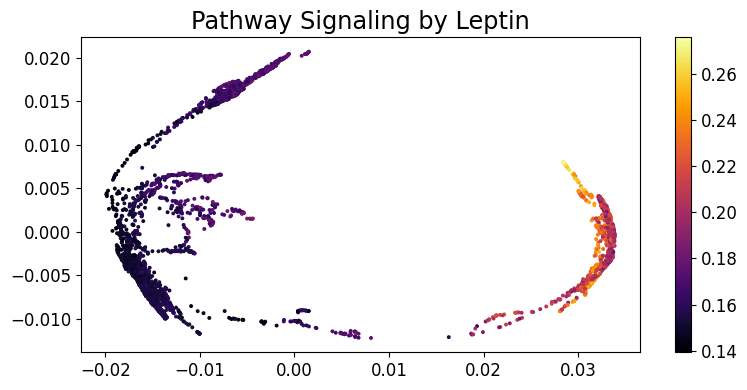

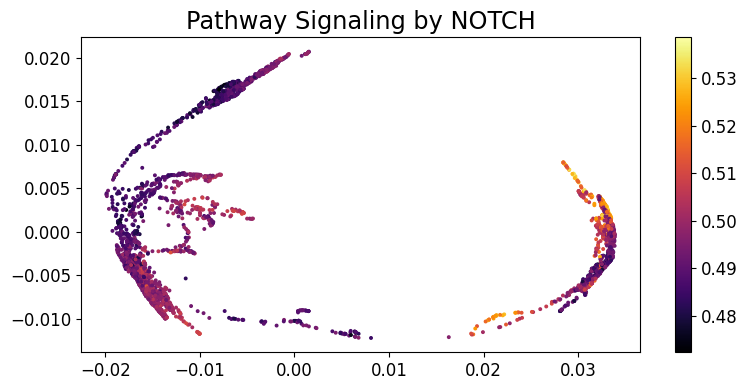

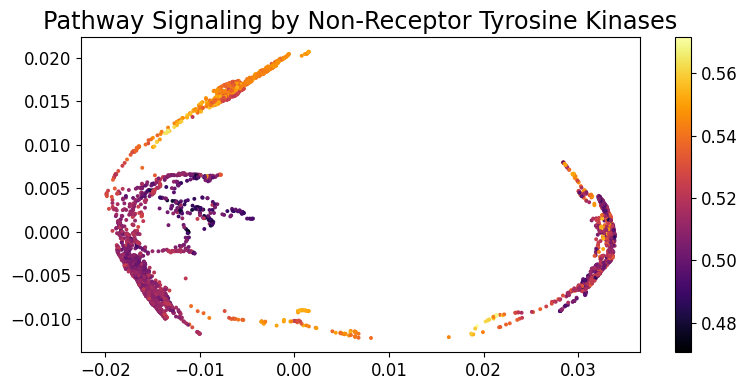

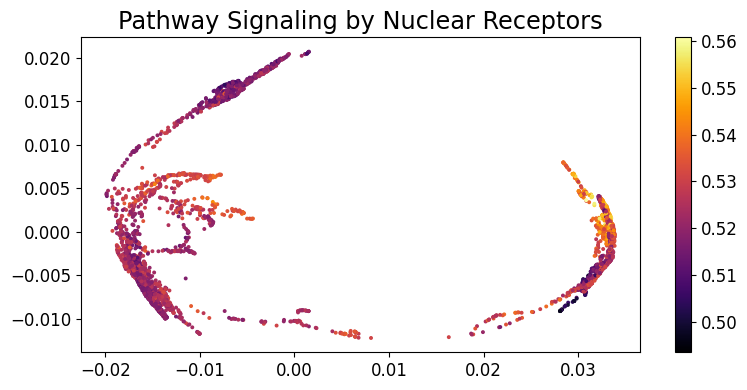

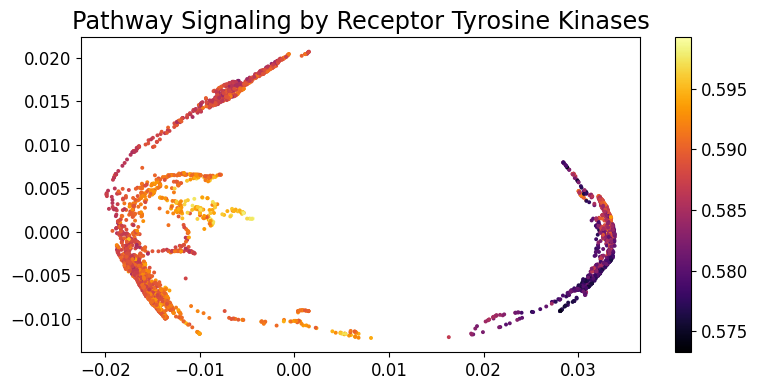

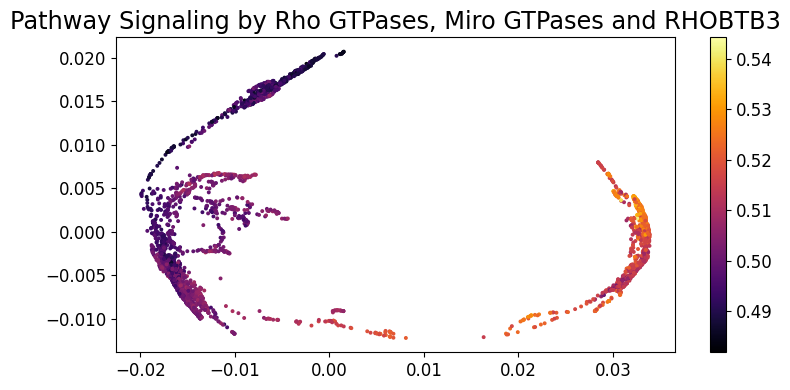

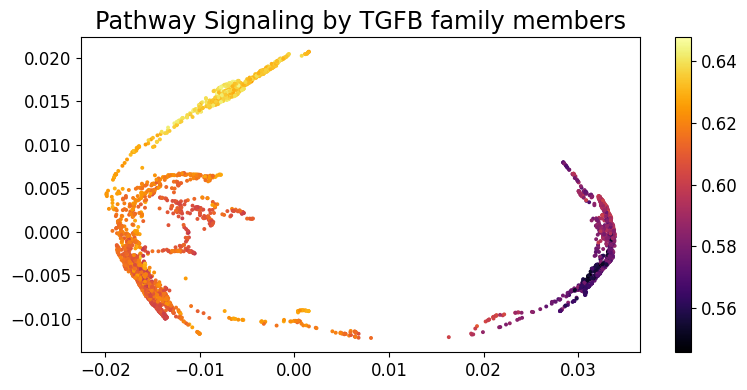

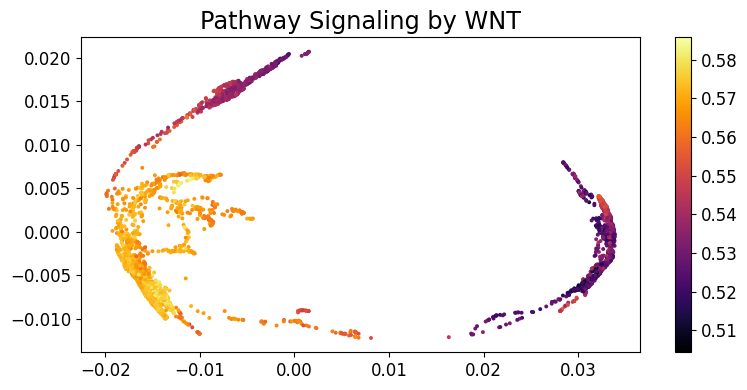

In [107]:
data_phate = phate.PHATE(n_jobs=-2, random_state=12).fit_transform(dMagicRnaSeq) 
scprep.plot.scatter2d(
        data_phate, 
        c=mdSEQ["finalPOPS"], 
        title=f"Clusters", 
        legend_loc=(1.05, 0), shuffle=True,
        figsize=(8,4), dpi=480)

for i in sPathSEQ.columns:
    scprep.plot.scatter2d(
        data_phate, 
        c=sPathSEQ[i], 
        title=f"Pathway {i}", 
        legend_loc=(1.05, 0), shuffle=True,
        figsize=(8,4), dpi=480)
    

Calculating PHATE...
  Running PHATE on 23145 observations and 25 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 15.18 seconds.
    Calculating affinities...
    Calculated affinities in 0.15 seconds.
  Calculated graph and diffusion operator in 15.35 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.14 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.23 seconds.
  Calculated landmark operator in 6.84 seconds.
  Calculating optimal t...
    Automatically selected t = 55
  Calculated optimal t in 1.11 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.66 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.67 seconds.
Calculated PHATE in 28.63 seconds.


/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw)


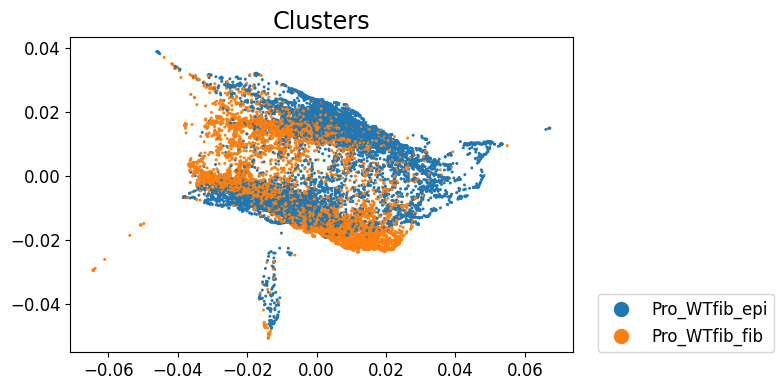

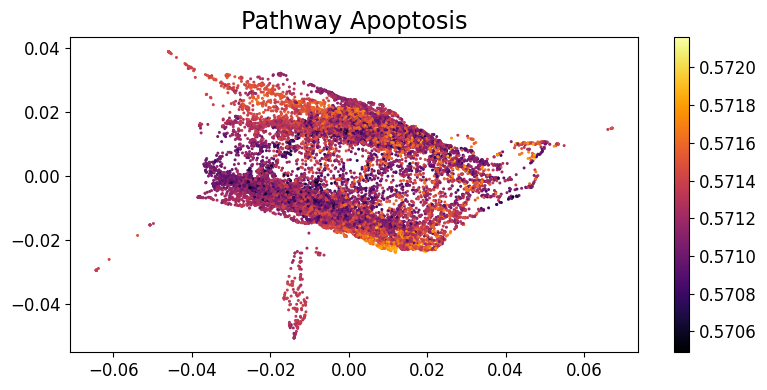

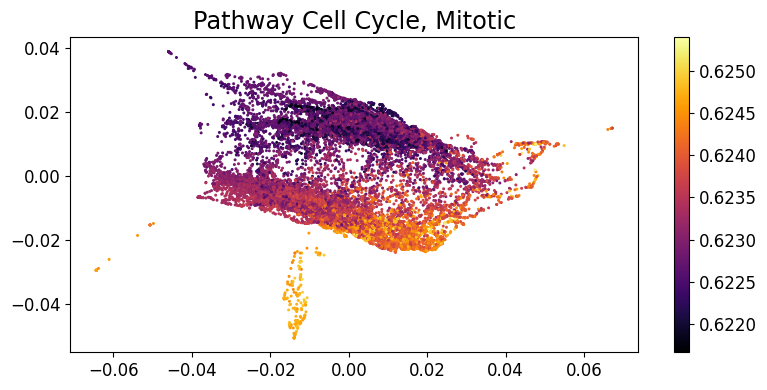

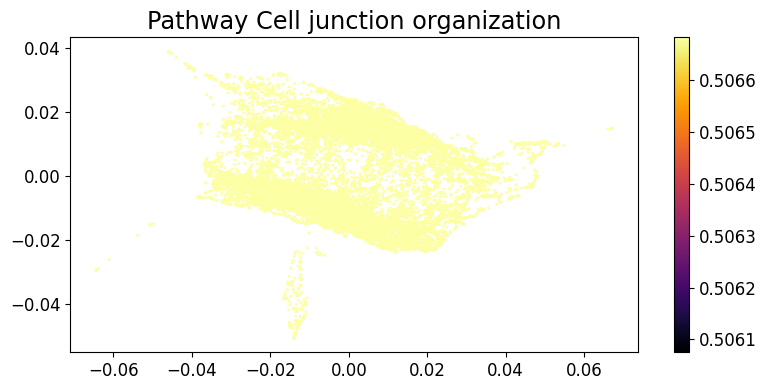

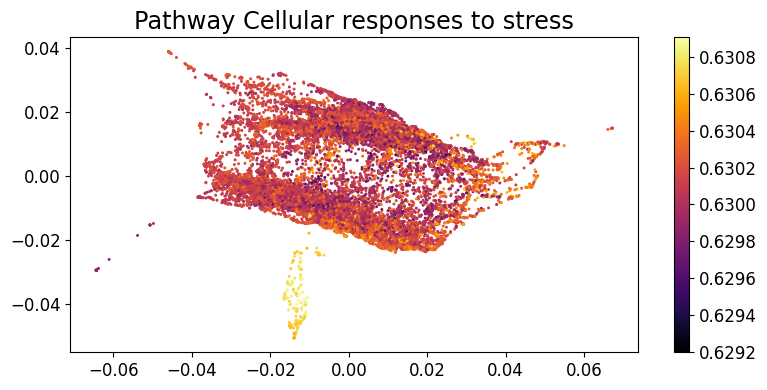

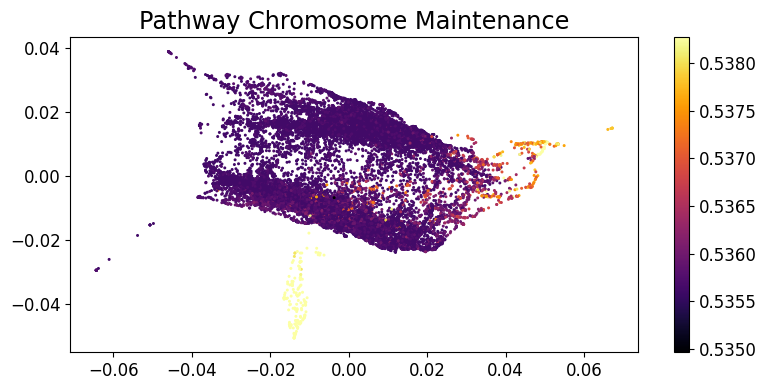

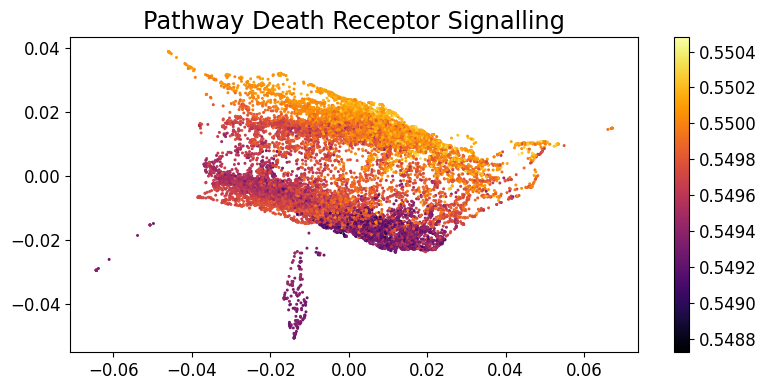

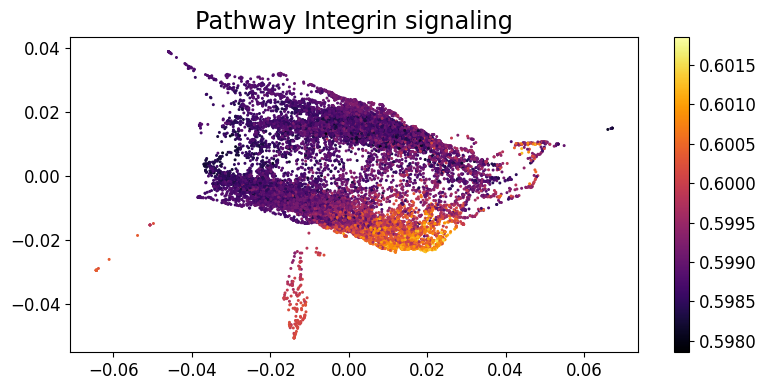

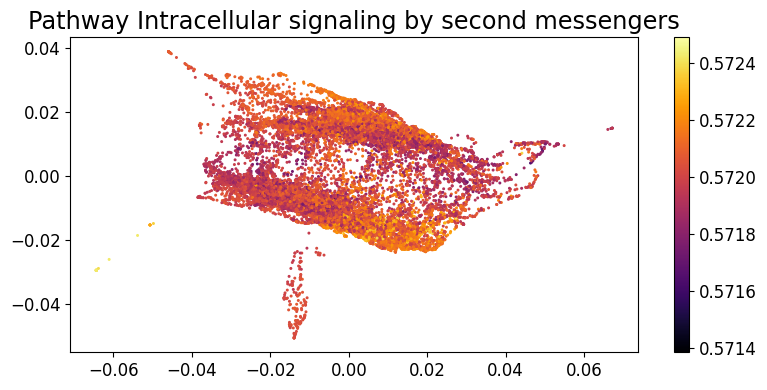

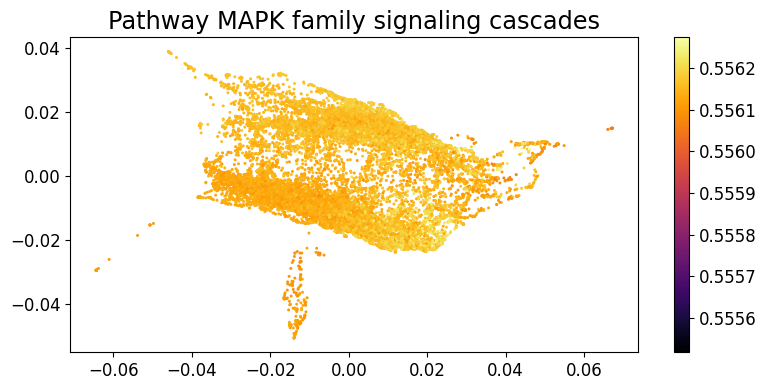

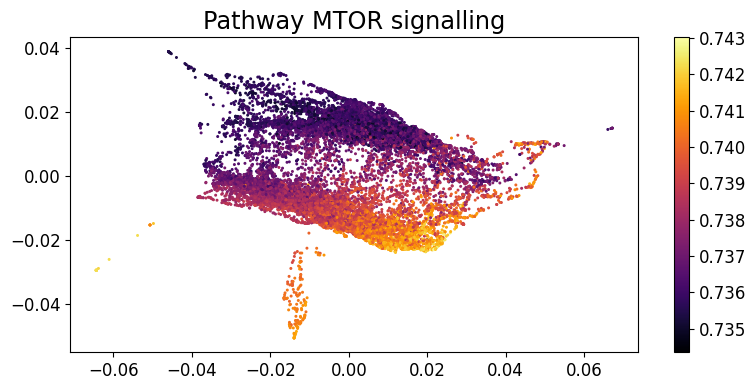

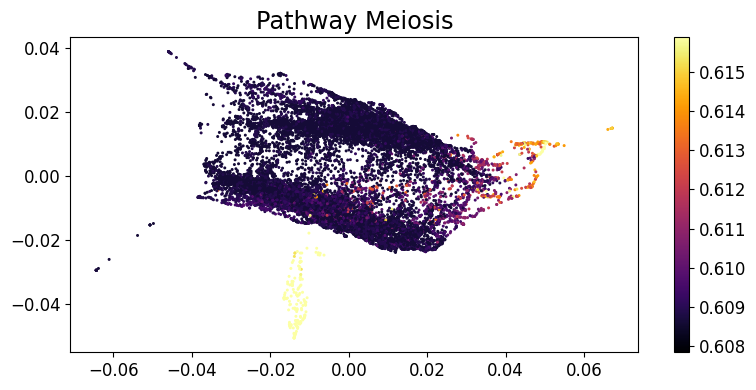

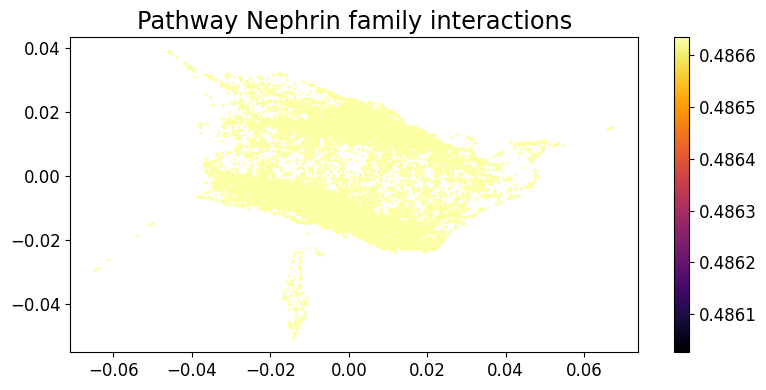

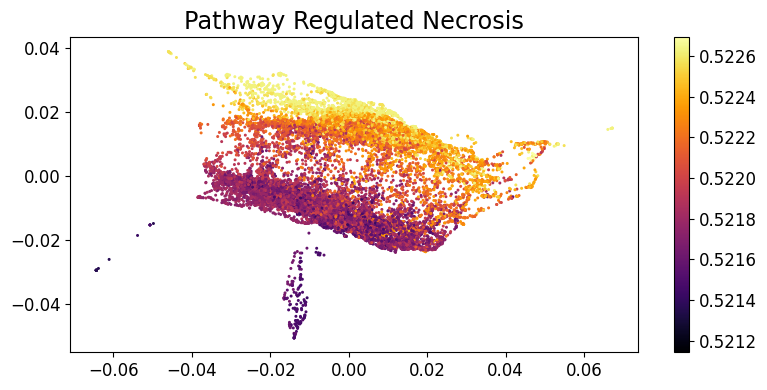

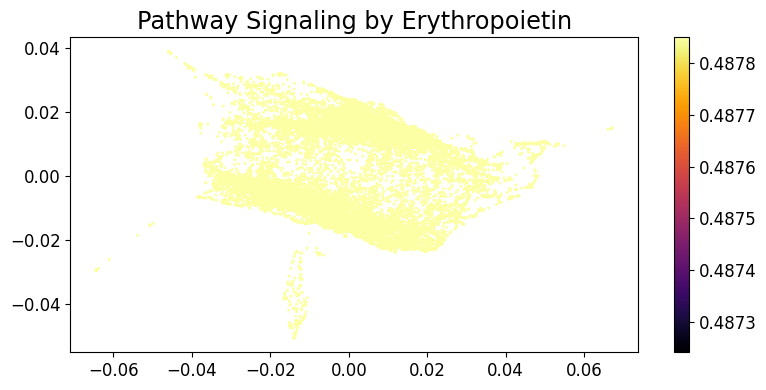

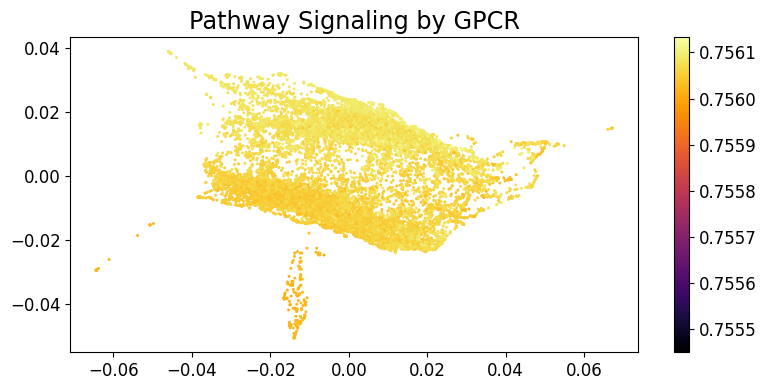

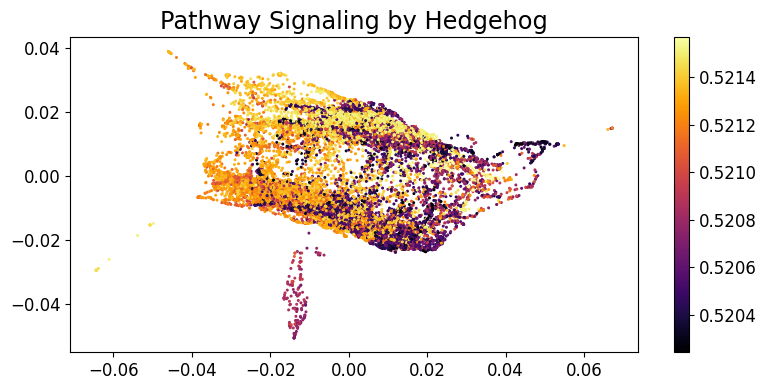

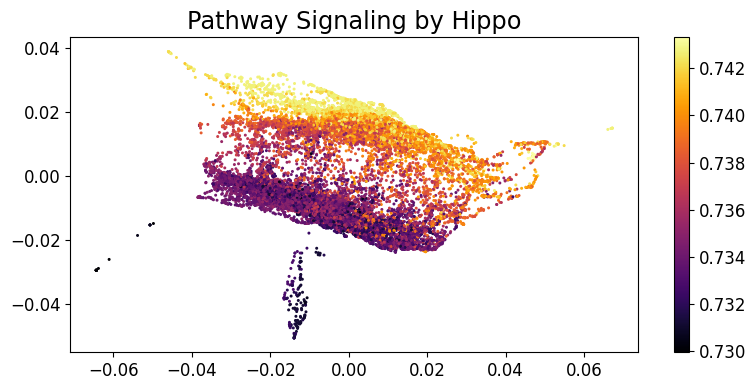

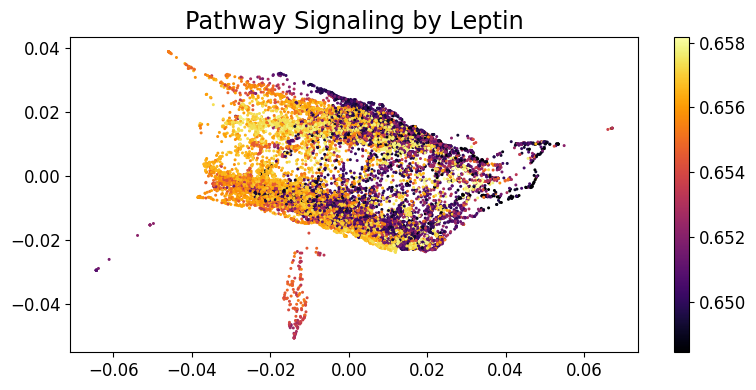

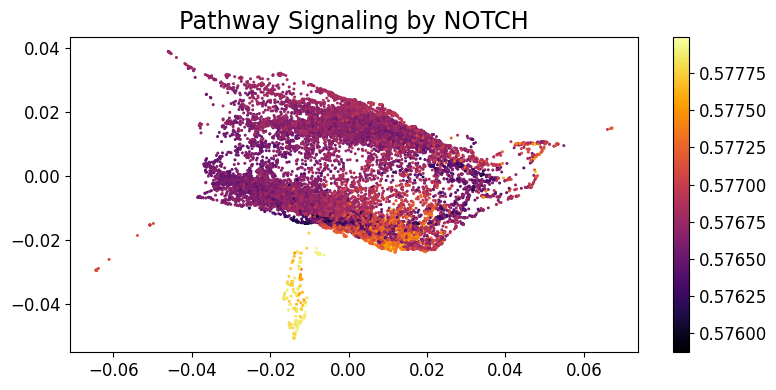

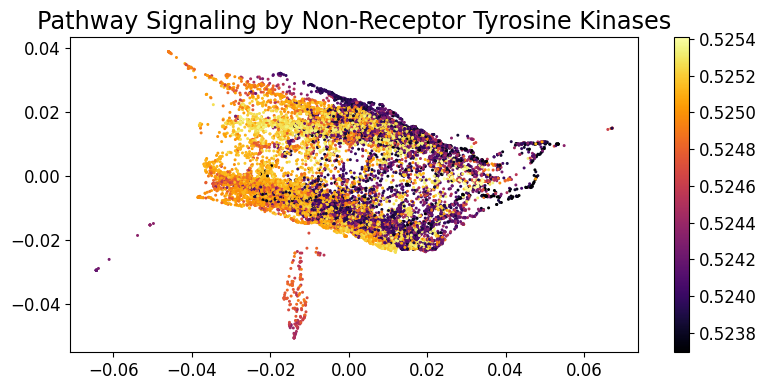

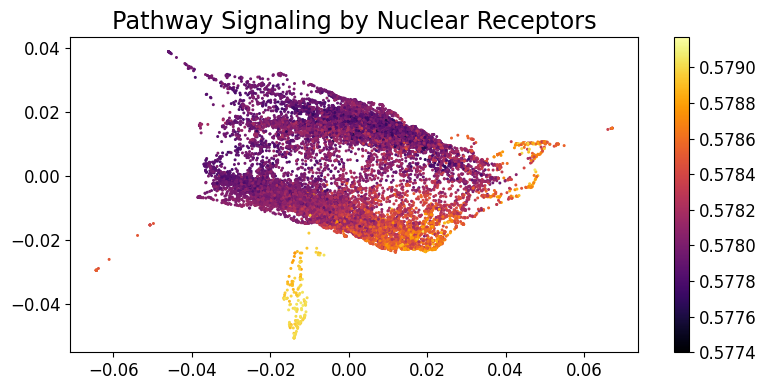

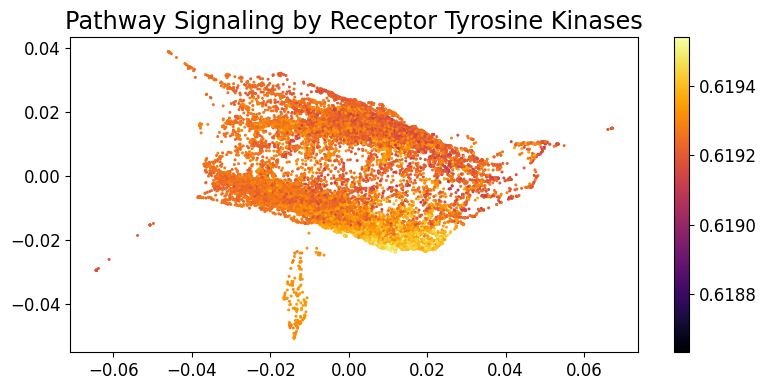

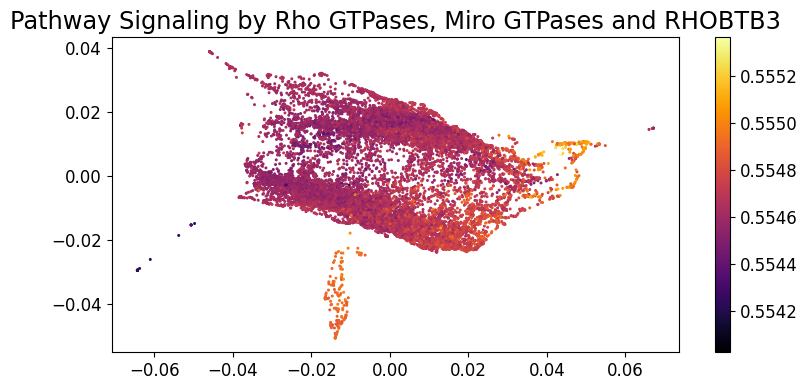

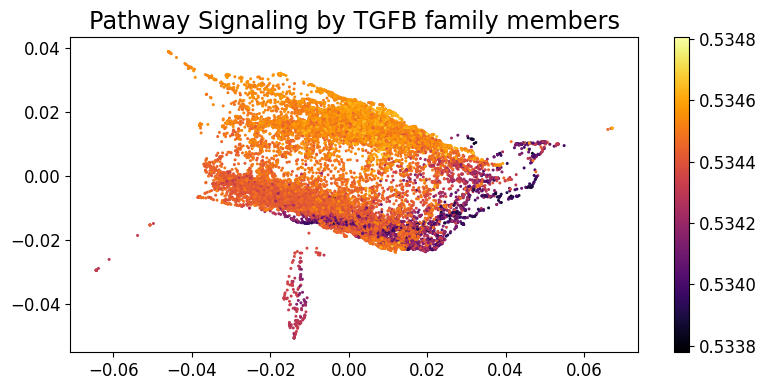

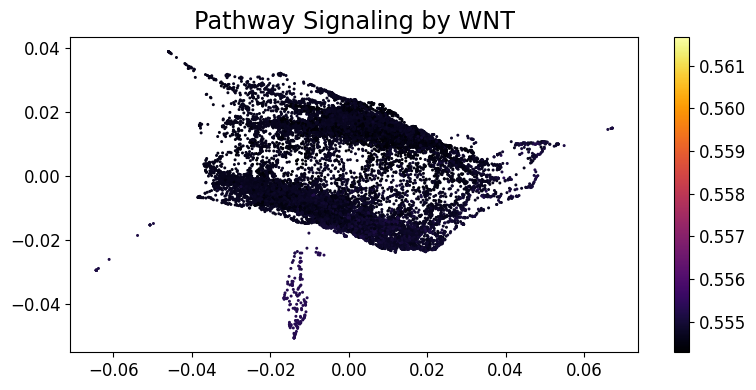

In [108]:
data_phate = phate.PHATE(n_jobs=-2, random_state=12).fit_transform(dMagicCyt) 
scprep.plot.scatter2d(
        data_phate, 
        c=mdCYT, 
        title=f"Clusters", 
        legend_loc=(1.05, 0), shuffle=True,
        figsize=(8,4), dpi=480)

for i in sPathSEQ.columns:
    scprep.plot.scatter2d(
        data_phate, 
        c=sPathCYT[i], 
        title=f"Pathway {i}", 
        legend_loc=(1.05, 0), shuffle=True,
        figsize=(8,4), dpi=480)